[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [1]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10, 
    out_channels=10, 
    kernel_size=2, 
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 10, 40, 40])

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=566341bfb7497c736412ab0c585351ad0b2296cdb50b0f9fff6bfcd0fb0be21a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [32]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs (1).zip'

In [33]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer. 

In [34]:
import os 
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

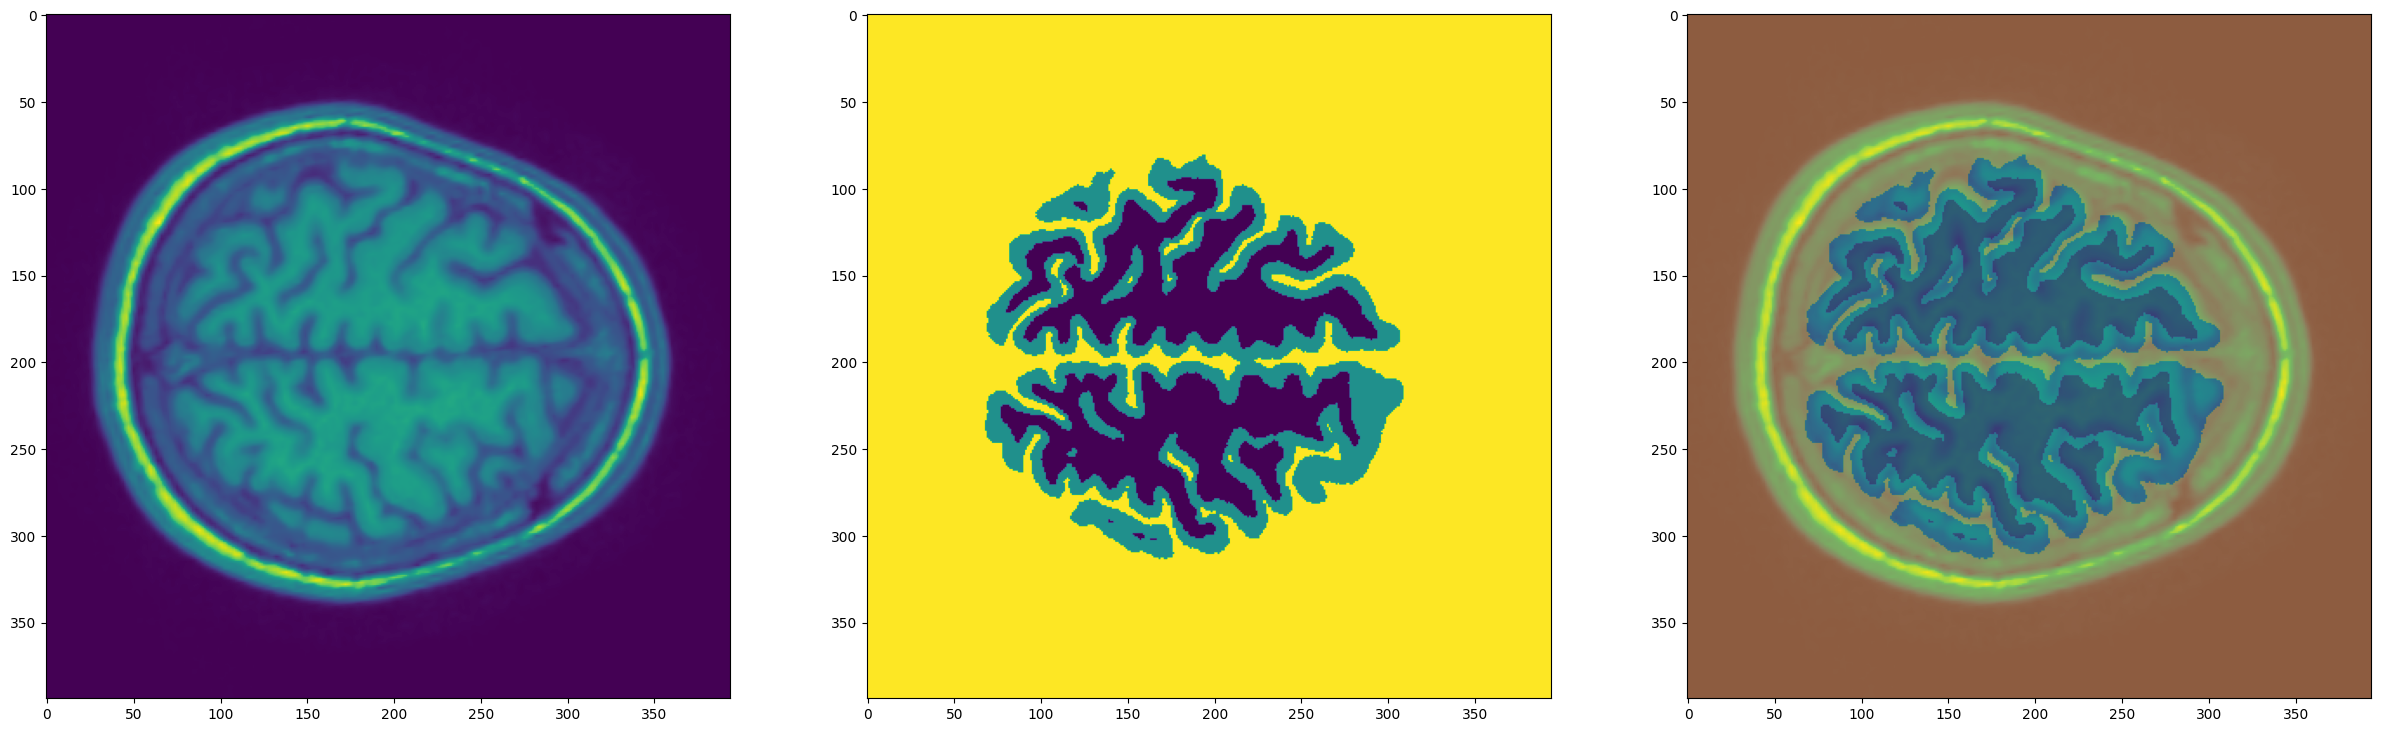

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [7]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.1072378, 0.00025629325)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [8]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [9]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [10]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [11]:
model = UNet()
output = model(torch.randn((10,1,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [13]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [14]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.74586
Epoch 2/20 loss 0.72021
Epoch 3/20 loss 0.69851
Epoch 4/20 loss 0.68040
Epoch 5/20 loss 0.66560
Epoch 6/20 loss 0.65450
Epoch 7/20 loss 0.64453
Epoch 8/20 loss 0.63513
Epoch 9/20 loss 0.62613
Epoch 10/20 loss 0.61752
Epoch 11/20 loss 0.60901
Epoch 12/20 loss 0.60045
Epoch 13/20 loss 0.59181
Epoch 14/20 loss 0.58332
Epoch 15/20 loss 0.57514
Epoch 16/20 loss 0.56716
Epoch 17/20 loss 0.55933
Epoch 18/20 loss 0.55173
Epoch 19/20 loss 0.54430
Epoch 20/20 loss 0.53697


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

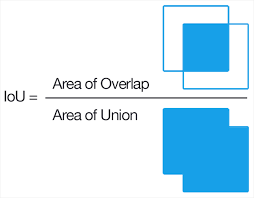

In [15]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [16]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [17]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.52977 iou 0.50010
Epoch 2/100 loss 0.51148 iou 0.52109
Epoch 3/100 loss 0.49094 iou 0.42024
Epoch 4/100 loss 0.46908 iou 0.40166
Epoch 5/100 loss 0.44833 iou 0.43289
Epoch 6/100 loss 0.43176 iou 0.40799
Epoch 7/100 loss 0.41344 iou 0.41359
Epoch 8/100 loss 0.39751 iou 0.40039
Epoch 9/100 loss 0.38179 iou 0.39772
Epoch 10/100 loss 0.36686 iou 0.40687
Epoch 11/100 loss 0.35338 iou 0.41484
Epoch 12/100 loss 0.33886 iou 0.41142
Epoch 13/100 loss 0.32528 iou 0.41804
Epoch 14/100 loss 0.31292 iou 0.42800
Epoch 15/100 loss 0.29999 iou 0.43414
Epoch 16/100 loss 0.28828 iou 0.43427
Epoch 17/100 loss 0.27619 iou 0.46861
Epoch 18/100 loss 0.26570 iou 0.50462
Epoch 19/100 loss 0.25481 iou 0.55033
Epoch 20/100 loss 0.24412 iou 0.60166
Epoch 21/100 loss 0.23478 iou 0.65413
Epoch 22/100 loss 0.22554 iou 0.66927
Epoch 23/100 loss 0.21543 iou 0.70109
Epoch 24/100 loss 0.20735 iou 0.73517
Epoch 25/100 loss 0.19809 iou 0.77683
Epoch 26/100 loss 0.19115 iou 0.76464
Epoch 27/100 loss 0.1

Ahora podemos generar predicciones para obtener máscaras de segmentación

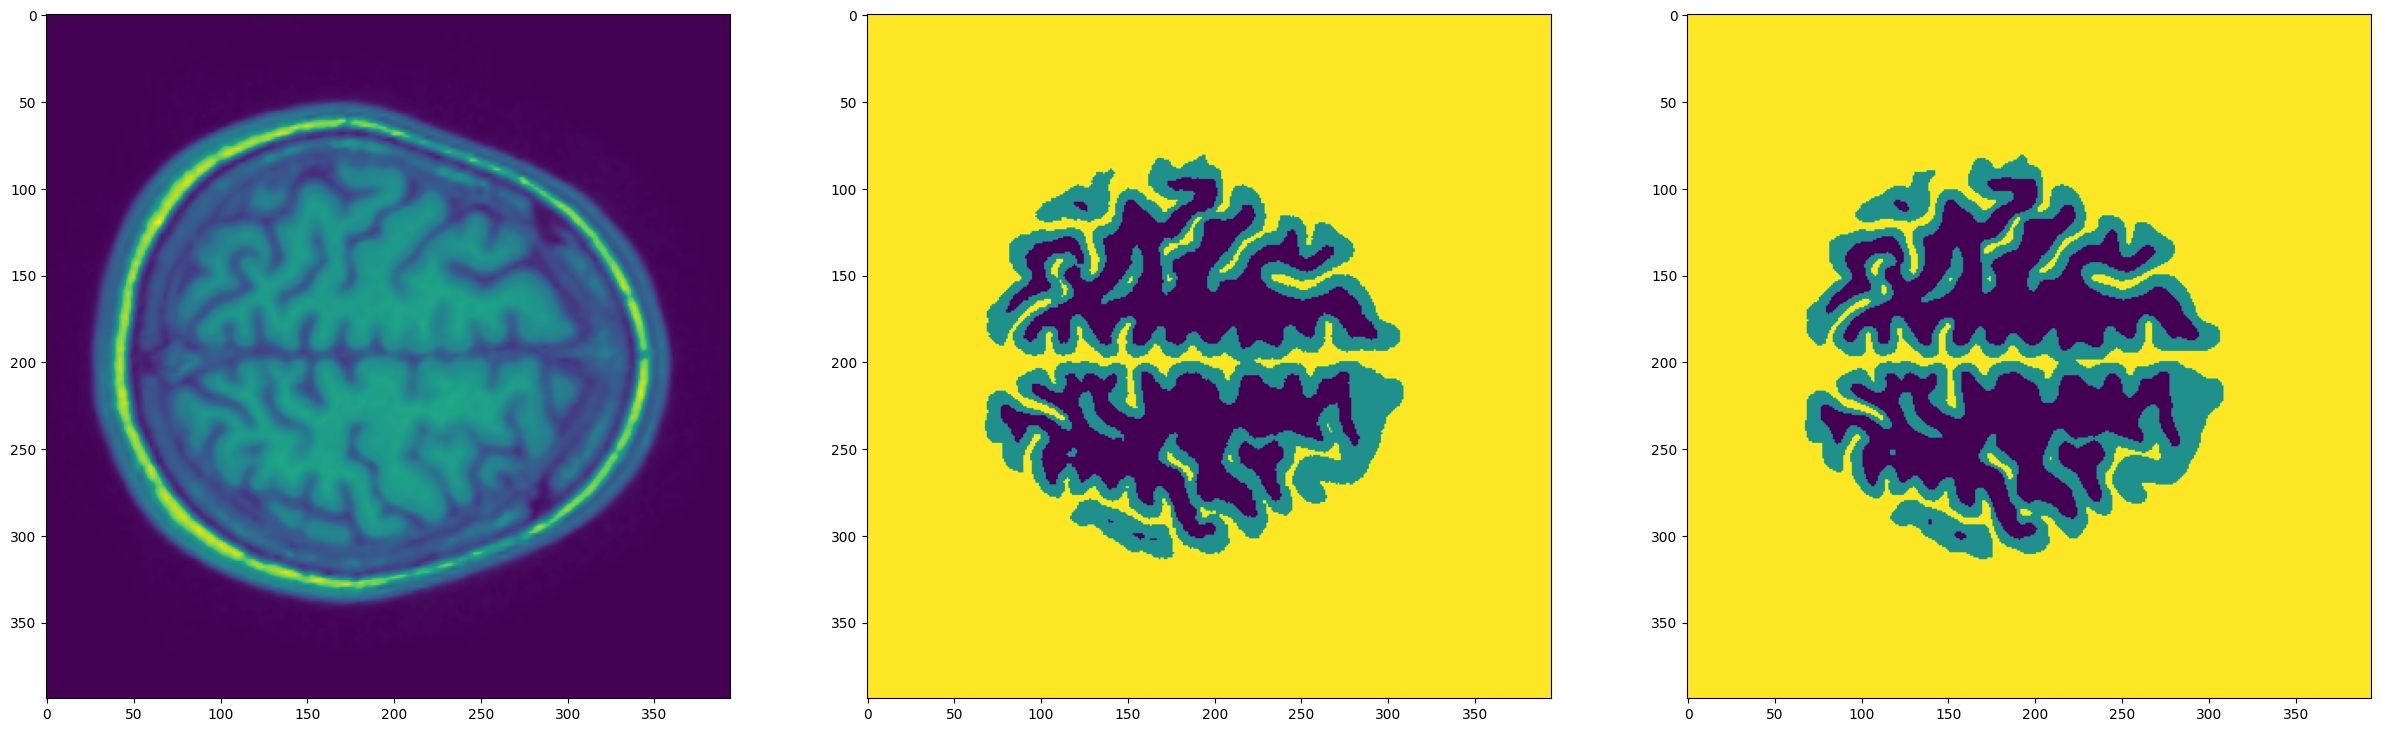

In [18]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [19]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [20]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [21]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [22]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [23]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.66381 test_iou 0.23034: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]



Epoch 1/30 loss 0.66023 iou 0.28247 test_loss 0.66381 test_iou 0.23034


test_loss 0.50041 test_iou 0.31220: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]



Epoch 2/30 loss 0.49289 iou 0.40105 test_loss 0.50041 test_iou 0.31220


test_loss 0.32060 test_iou 0.56660: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



Epoch 3/30 loss 0.36692 iou 0.49618 test_loss 0.32060 test_iou 0.56660


test_loss 0.24291 test_iou 0.63160: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



Epoch 4/30 loss 0.28178 iou 0.63109 test_loss 0.24291 test_iou 0.63160


test_loss 0.20741 test_iou 0.67110: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



Epoch 5/30 loss 0.22740 iou 0.66612 test_loss 0.20741 test_iou 0.67110


test_loss 0.18932 test_iou 0.66077: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]



Epoch 6/30 loss 0.18970 iou 0.69293 test_loss 0.18932 test_iou 0.66077


test_loss 0.15910 test_iou 0.68801: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]



Epoch 7/30 loss 0.16398 iou 0.70364 test_loss 0.15910 test_iou 0.68801


test_loss 0.14015 test_iou 0.71595: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



Epoch 8/30 loss 0.14426 iou 0.71396 test_loss 0.14015 test_iou 0.71595


test_loss 0.13019 test_iou 0.70988: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]



Epoch 9/30 loss 0.13043 iou 0.71868 test_loss 0.13019 test_iou 0.70988


test_loss 0.11616 test_iou 0.72878: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]



Epoch 10/30 loss 0.11938 iou 0.72324 test_loss 0.11616 test_iou 0.72878


test_loss 0.11307 test_iou 0.71712: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]



Epoch 11/30 loss 0.10971 iou 0.73165 test_loss 0.11307 test_iou 0.71712


test_loss 0.10346 test_iou 0.73000: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 12/30 loss 0.10476 iou 0.72759 test_loss 0.10346 test_iou 0.73000


test_loss 0.09479 test_iou 0.74479: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]



Epoch 13/30 loss 0.09604 iou 0.74247 test_loss 0.09479 test_iou 0.74479


test_loss 0.09430 test_iou 0.73314: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]



Epoch 14/30 loss 0.09076 iou 0.74744 test_loss 0.09430 test_iou 0.73314


test_loss 0.09031 test_iou 0.73308: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]



Epoch 15/30 loss 0.08620 iou 0.75100 test_loss 0.09031 test_iou 0.73308


test_loss 0.08862 test_iou 0.72533: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]



Epoch 16/30 loss 0.08170 iou 0.75832 test_loss 0.08862 test_iou 0.72533


test_loss 0.08314 test_iou 0.75159: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 17/30 loss 0.07977 iou 0.75588 test_loss 0.08314 test_iou 0.75159


test_loss 0.08306 test_iou 0.73530: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]



Epoch 18/30 loss 0.07671 iou 0.75930 test_loss 0.08306 test_iou 0.73530


test_loss 0.07689 test_iou 0.75682: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]



Epoch 19/30 loss 0.07446 iou 0.76100 test_loss 0.07689 test_iou 0.75682


test_loss 0.07930 test_iou 0.74440: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]



Epoch 20/30 loss 0.07223 iou 0.76309 test_loss 0.07930 test_iou 0.74440


test_loss 0.07488 test_iou 0.75427: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 21/30 loss 0.06936 iou 0.76941 test_loss 0.07488 test_iou 0.75427


test_loss 0.07233 test_iou 0.75957: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]



Epoch 22/30 loss 0.06602 iou 0.77739 test_loss 0.07233 test_iou 0.75957


test_loss 0.07060 test_iou 0.76184: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]



Epoch 23/30 loss 0.06370 iou 0.78281 test_loss 0.07060 test_iou 0.76184


test_loss 0.06980 test_iou 0.76280: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]



Epoch 24/30 loss 0.06333 iou 0.78026 test_loss 0.06980 test_iou 0.76280


test_loss 0.06838 test_iou 0.76586: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 25/30 loss 0.06147 iou 0.78424 test_loss 0.06838 test_iou 0.76586


test_loss 0.07081 test_iou 0.74778: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]



Epoch 26/30 loss 0.06106 iou 0.78287 test_loss 0.07081 test_iou 0.74778


test_loss 0.07094 test_iou 0.74595: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]



Epoch 27/30 loss 0.06186 iou 0.77744 test_loss 0.07094 test_iou 0.74595


test_loss 0.06591 test_iou 0.76892: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



Epoch 28/30 loss 0.05836 iou 0.78793 test_loss 0.06591 test_iou 0.76892


test_loss 0.06535 test_iou 0.76145: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]



Epoch 29/30 loss 0.05700 iou 0.79125 test_loss 0.06535 test_iou 0.76145


test_loss 0.06531 test_iou 0.76533: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Epoch 30/30 loss 0.05456 iou 0.79805 test_loss 0.06531 test_iou 0.76533


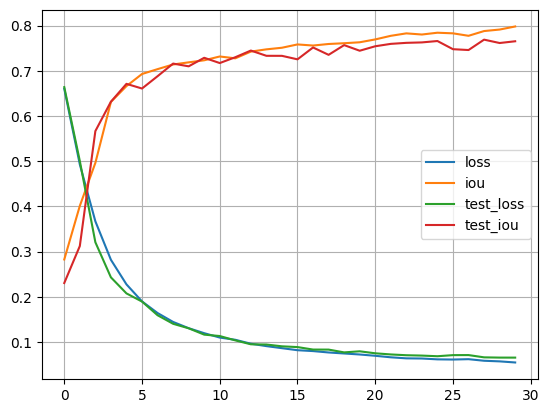

In [24]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [25]:
import torchvision

In [26]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 326MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [28]:
model = UNetResnet()
output = model(torch.randn((10,1,394,394)))
output.shape

<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 3, 394, 394])

In [29]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.60443 test_iou 0.31649: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]



Epoch 1/30 loss 0.51250 iou 0.41366 test_loss 0.60443 test_iou 0.31649


test_loss 0.41872 test_iou 0.61065: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]



Epoch 2/30 loss 0.39156 iou 0.65155 test_loss 0.41872 test_iou 0.61065


test_loss 0.33605 test_iou 0.67354: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]



Epoch 3/30 loss 0.34055 iou 0.70030 test_loss 0.33605 test_iou 0.67354


test_loss 0.30685 test_iou 0.67740: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]



Epoch 4/30 loss 0.30150 iou 0.72453 test_loss 0.30685 test_iou 0.67740


test_loss 0.27154 test_iou 0.73018: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]



Epoch 5/30 loss 0.26923 iou 0.73664 test_loss 0.27154 test_iou 0.73018


test_loss 0.24161 test_iou 0.73510: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]



Epoch 6/30 loss 0.24027 iou 0.75390 test_loss 0.24161 test_iou 0.73510


test_loss 0.21451 test_iou 0.74200: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]



Epoch 7/30 loss 0.21549 iou 0.76762 test_loss 0.21451 test_iou 0.74200


test_loss 0.19351 test_iou 0.76811: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]



Epoch 8/30 loss 0.19319 iou 0.78395 test_loss 0.19351 test_iou 0.76811


test_loss 0.17423 test_iou 0.78164: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]



Epoch 9/30 loss 0.17386 iou 0.79747 test_loss 0.17423 test_iou 0.78164


test_loss 0.16500 test_iou 0.74645: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



Epoch 10/30 loss 0.15719 iou 0.80789 test_loss 0.16500 test_iou 0.74645


test_loss 0.14592 test_iou 0.78610: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]



Epoch 11/30 loss 0.14109 iou 0.82630 test_loss 0.14592 test_iou 0.78610


test_loss 0.13282 test_iou 0.79515: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



Epoch 12/30 loss 0.12787 iou 0.83678 test_loss 0.13282 test_iou 0.79515


test_loss 0.12008 test_iou 0.80639: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]



Epoch 13/30 loss 0.11724 iou 0.84068 test_loss 0.12008 test_iou 0.80639


test_loss 0.11290 test_iou 0.81342: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



Epoch 14/30 loss 0.10683 iou 0.85066 test_loss 0.11290 test_iou 0.81342


test_loss 0.10649 test_iou 0.80682: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]



Epoch 15/30 loss 0.09793 iou 0.85709 test_loss 0.10649 test_iou 0.80682


test_loss 0.10282 test_iou 0.79357: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]



Epoch 16/30 loss 0.09056 iou 0.86091 test_loss 0.10282 test_iou 0.79357


test_loss 0.09581 test_iou 0.80607: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 17/30 loss 0.08499 iou 0.86071 test_loss 0.09581 test_iou 0.80607


test_loss 0.09090 test_iou 0.81309: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Epoch 18/30 loss 0.07753 iou 0.87219 test_loss 0.09090 test_iou 0.81309


test_loss 0.08486 test_iou 0.81853: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 19/30 loss 0.07233 iou 0.87550 test_loss 0.08486 test_iou 0.81853


test_loss 0.08554 test_iou 0.80549: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 20/30 loss 0.06714 iou 0.88290 test_loss 0.08554 test_iou 0.80549


test_loss 0.07906 test_iou 0.81385: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Epoch 21/30 loss 0.06476 iou 0.87681 test_loss 0.07906 test_iou 0.81385


test_loss 0.07456 test_iou 0.82511: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]



Epoch 22/30 loss 0.06010 iou 0.88547 test_loss 0.07456 test_iou 0.82511


test_loss 0.07324 test_iou 0.82202: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 23/30 loss 0.05599 iou 0.89145 test_loss 0.07324 test_iou 0.82202


test_loss 0.07229 test_iou 0.81686: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Epoch 24/30 loss 0.05218 iou 0.89913 test_loss 0.07229 test_iou 0.81686


test_loss 0.07396 test_iou 0.80189: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 25/30 loss 0.05084 iou 0.89316 test_loss 0.07396 test_iou 0.80189


test_loss 0.07134 test_iou 0.80960: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]



Epoch 26/30 loss 0.04864 iou 0.89437 test_loss 0.07134 test_iou 0.80960


test_loss 0.06640 test_iou 0.82125: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]



Epoch 27/30 loss 0.04554 iou 0.90127 test_loss 0.06640 test_iou 0.82125


test_loss 0.06960 test_iou 0.80855: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Epoch 28/30 loss 0.04467 iou 0.89646 test_loss 0.06960 test_iou 0.80855


test_loss 0.06402 test_iou 0.82480: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



Epoch 29/30 loss 0.04291 iou 0.89797 test_loss 0.06402 test_iou 0.82480


test_loss 0.06294 test_iou 0.82265: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 30/30 loss 0.03975 iou 0.90817 test_loss 0.06294 test_iou 0.82265


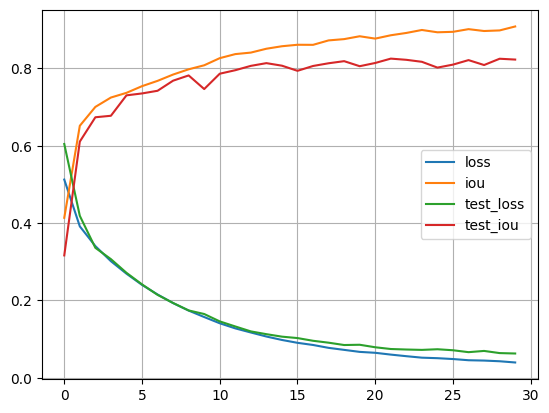

In [30]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


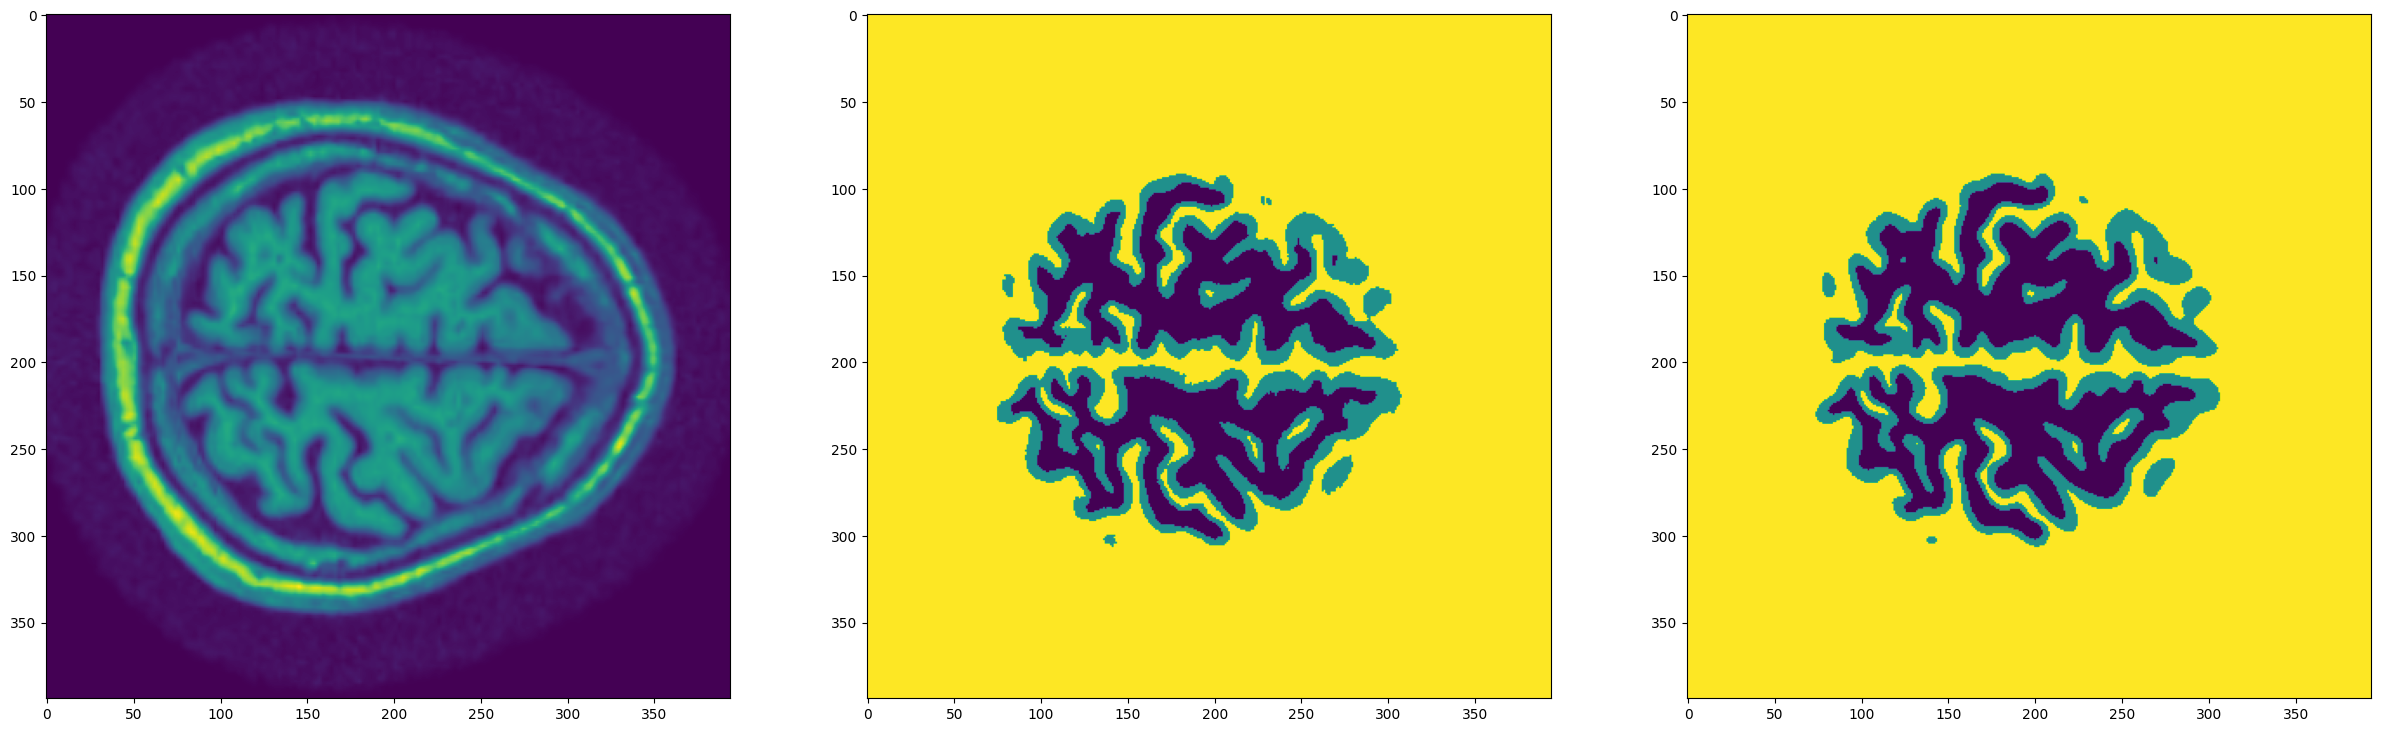

In [31]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.